In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, Visualization_Setting, set_figure_label_and_limit, contact_optimization, get_fixed_boundary_joint, show_selected_joints)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
# rod_length = curved_linkage.totalRestLength() / curved_linkage.numSegments()
rod_length = 0.079785061039255
width = rod_length / 25 * 5
thickness = width / 5 * 0.5
print(width, thickness)
scale = 1
io = InputOrganizer('nest_chair_{}'.format(scale), thickness, width, weaving_dir)

0.015957012207851003 0.0015957012207851004


In [4]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False

In [5]:
rw = 0.01
sw = 0.01

In [6]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [7]:
curved_linkage.setExtendedDoFsPSRL(np.load('../benchmark/dofs/benchmark_nest_chair_1_dof.npy'))

In [8]:
curved_linkage.attraction_weight = 1e-5

In [9]:
# set_surface_view_options(curved_linkage_view, surface_transparent=False)


In [10]:
# iterateData = stage_1_optimization(curved_linkage, rw, sw, curved_linkage_view)

In [11]:
fixed_boundary_joints = get_fixed_boundary_joint(curved_linkage)

In [12]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [13]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = fixed_boundary_joints)

0	0.00132621	0.457708	0.457708	1	1
1	9.75595e-05	0.0701529	0.0701529	1	1
2	4.63715e-05	0.0132298	0.0132298	1	1
3	3.1876e-05	0.0045189	0.0045189	1	1
4	2.1968e-05	0.00211511	0.00211511	1	1
5	1.50283e-05	0.00107383	0.00107383	1	1
6	1.08434e-05	0.000587538	0.000587538	1	1
7	8.71316e-06	0.000318788	0.000318788	1	1
8	7.7209e-06	0.000172673	0.000172673	1	1
9	7.2661e-06	9.26571e-05	9.26571e-05	1	1
10	7.065e-06	4.80058e-05	4.80058e-05	1	1
11	6.98336e-06	2.43115e-05	2.43115e-05	1	0
12	6.97707e-06	0.000591999	0.000591999	1	0
13	6.93211e-06	1.06864e-05	1.06864e-05	1	1
14	6.93209e-06	3.86048e-07	3.86048e-07	1	1
15	6.93207e-06	2.92031e-07	2.92031e-07	1	1
16	6.93206e-06	2.26972e-07	2.26972e-07	1	1
17	6.93204e-06	1.75257e-07	1.75257e-07	1	1
18	6.93202e-06	1.3716e-07	1.3716e-07	1	1
19	6.93199e-06	1.11808e-07	1.11808e-07	1	1
20	6.93195e-06	1.04034e-07	1.04034e-07	1	1
21	6.93191e-06	1.41015e-07	1.41015e-07	1	1
22	6.93186e-06	2.47235e-07	2.47235e-07	1	1
23	6.93178e-06	5.56288e-07	5.56288e-07	1	1
Computing

In [16]:
vf = show_selected_joints(curved_linkage, [237,414,238,349,349,237,390,238,348,392,350,261,350,263,584,383,262,311,469,351,382,352,209,351,389,312,228,311,351,405,272,565,164,273,370,371,405,388,165,310,112,292,110,270,113,112,387,111,291,418,110,156,386,596,419,418,308,155,372,156,158,99,100,318,159,373,157,158,227,505])
curved_linkage_view.update(vectorField = vf)

In [11]:
# optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = fixed_boundary_joints)
# optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

stage 2 optimization with attraction weight 100.0
stage 2 optimization with attraction weight 0.03162277660168379
stage 2 optimization with attraction weight 1e-05


In [14]:
# curved_optimizer_energy = curved_linkage.energy()
# validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
# validation_curved_linkage.attraction_weight = 1e-7
# with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = fixed_boundary_joints)
# validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
# validation_curved_energy = validation_curved_linkage.energy()
# print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

1.1868447778439797e-06


In [13]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(curved_linkage)

In [17]:
validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
set_surface_view_options(validation_curved_view)
validation_curved_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [17]:
set_joint_vector_field(curved_linkage, curved_linkage_view, deviation_vector)

Min Width  0.015957012207851003
num seg per rod 14
num seg per rod 26
num seg per rod 25
num seg per rod 35
num seg per rod 25
num seg per rod 26
num seg per rod 29
num seg per rod 8
num seg per rod 21
num seg per rod 37
num seg per rod 12
num seg per rod 20
num seg per rod 27
num seg per rod 30
num seg per rod 23
num seg per rod 19
num seg per rod 36
num seg per rod 31
num seg per rod 32
num seg per rod 9
num seg per rod 35
num seg per rod 27
num seg per rod 30
num seg per rod 38
num seg per rod 27
num seg per rod 26
num seg per rod 26
num seg per rod 33
num seg per rod 27
num seg per rod 23
num seg per rod 89
num seg per rod 16
num seg per rod 24
num seg per rod 11
num seg per rod 12
num seg per rod 10
num seg per rod 8
num seg per rod 30
num seg per rod 10
num seg per rod 23
num seg per rod 7
num seg per rod 5
num seg per rod 19
num seg per rod 31
num seg per rod 30
num seg per rod 9
num seg per rod 24
num seg per rod 18


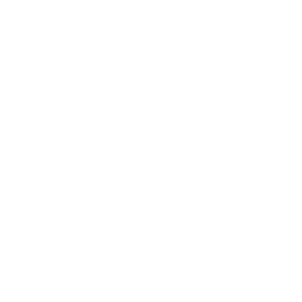

In [16]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)